In [20]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import vgg19
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib as mpl
from PIL import Image
import time
import functools



base_image_path ='japanese_garden.jpg'
style_image_path ='picasso_selfportrait.jpg'

In [21]:
def load_img(path_to_img):
    max_dim = 512
    img = tf.io.read_file(path_to_img)
    img = tf.image.decode_image(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
#     print(tf.shape(img))
    shape = tf.cast(tf.shape(img)[:-1], tf.float32)
    long_dim = max(shape)
    scale = max_dim / long_dim
    new_shape = tf.cast(shape * scale, tf.int32)
    img = tf.image.resize(img, new_shape)
    img = img[tf.newaxis, :]
    return img
    

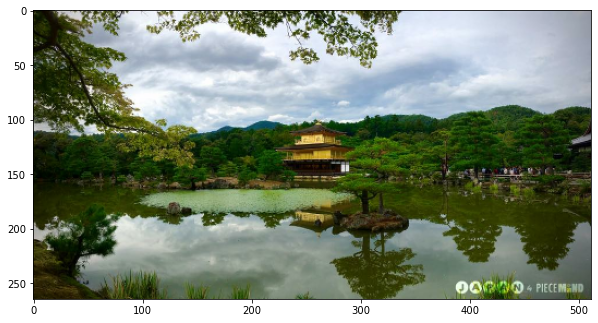

In [24]:
def imshow(image, title=None):
    if len(image.shape) > 3:
        image = tf.squeeze(image, axis=0)

    plt.imshow(image)
    if title:
        plt.title(title)
        
base_image = load_img(base_image_path)
imshow(base_image)


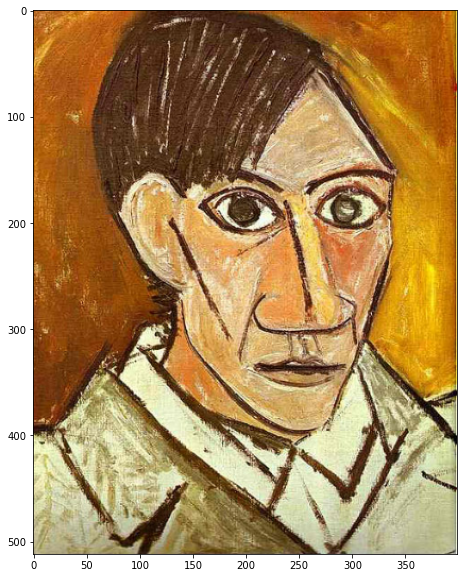

In [25]:
style_image = load_img(style_image_path)
imshow(style_image)

In [ ]:
total_variation_weight = 1e-6
style_weight = 1e-6
content_weight = 2.5e-8

# Dimensions of the generated picture.
width, height = keras.preprocessing.image.load_img(base_image_path).size
img_nrows = 400
img_ncols = int(width * img_nrows / height)

In [ ]:
def preprocess_image(image_path):
    img = load_img(image_path, target_size=(resized_width, resized_height))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = vgg19.preprocess_input(img)
    return tf.convert_to_tensor(img)

In [ ]:
def deprocess_image(x):
    # Util function to convert a tensor into a valid image
    x = x.reshape((img_nrows, img_ncols, 3))
    # Remove zero-center by mean pixel
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    # 'BGR'->'RGB'
    x = x[:, :, ::-1]
    x = np.clip(x, 0, 255).astype("uint8")
    return x

In [ ]:

def gram_matrix(x):
    x = tf.transpose(x, (2, 0, 1))
    features = tf.reshape(x, (tf.shape(x)[0], -1))
    gram = tf.matmul(features, tf.transpose(features))
    return gram

#style loss
def style_loss(style, combination):
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = img_nrows * img_ncols
    return tf.reduce_sum(tf.square(S - C)) / (4.0 * (channels ** 2) * (size ** 2))

#content loss
def content_loss(base, combination):
    return tf.reduce_sum(tf.square(combination - base))

#total loss
def total_variation_loss(x):
    a = tf.square(x[:, : img_nrows - 1, : img_ncols - 1, :] - x[:, 1:, : img_ncols - 1, :])
    b = tf.square(x[:, : img_nrows - 1, : img_ncols - 1, :] - x[:, : img_nrows - 1, 1:, :])
    return tf.reduce_sum(tf.pow(a + b, 1.25))

In [ ]:
from tensorflow.keras.models import Model
from tensorflow import keras
model = vgg19.VGG19(weights="imagenet", include_top=False)

outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])

feature_extractor = tf.keras.Model(inputs=model.inputs, outputs=outputs_dict)

#style layers
style_layer_names = [
    "block1_conv1",
    "block2_conv1",
    "block3_conv1",
    "block4_conv1",
    "block5_conv1",
]
# layer to use for the content loss.
content_layer_name = "block5_conv2"

In [ ]:
def compute_loss(combination_image, base_image, style_reference_image):
    input_tensor = tf.concat(
        [base_image, style_reference_image, combination_image], axis=0
    )
    features = feature_extractor(input_tensor)

    # Initialize the loss
    loss = tf.zeros(shape=())

    # Add content loss
    layer_features = features[content_layer_name]
    base_image_features = layer_features[0, :, :, :]
    combination_features = layer_features[2, :, :, :]
    loss = loss + content_weight * content_loss(
        base_image_features, combination_features
    )
    # Add style loss
    for layer_name in style_layer_names:
        layer_features = features[layer_name]
        style_reference_features = layer_features[1, :, :, :]
        combination_features = layer_features[2, :, :, :]
        sl = style_loss(style_reference_features, combination_features)
        loss += (style_weight / len(style_layer_names)) * sl

    # Add total variation loss
    loss += total_variation_weight * total_variation_loss(combination_image)
    return loss

In [ ]:
pip install keras==2.3.1

In [ ]:
@tf.function
def compute_loss_and_grads(combination_image, base_image, style_reference_image):
    with tf.GradientTape() as tape:
        loss = compute_loss(combination_image, base_image, style_reference_image)
    grads = tape.gradient(loss, combination_image)
    return loss, grads


In [ ]:
optimizer = keras.optimizers.SGD(keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=100.0, decay_steps=100, decay_rate=0.96))

base_image = preprocess_image(base_image_path)
style_reference_image = preprocess_image(style_image_path)
combination_image = tf.Variable(preprocess_image(base_image_path))

#applying gradient descent for minimizing losses between combination image and input images
iterations = 500
result_prefix = "picture_generated"
for i in range(1, iterations + 1):
    loss, grads = compute_loss_and_grads(
        combination_image, base_image, style_reference_image
    )
    optimizer.apply_gradients([(grads, combination_image)])
    if i % 10 == 0:
        print("Iteration %d: loss=%.2f" % (i, loss))
        img = deprocess_image(combination_image.numpy())
        fname = result_prefix + "_at_iteration_%d.png" % i
        keras.preprocessing.image.save_img(fname, img)

Iteration 10: loss=15840.52
Iteration 20: loss=11750.60
Iteration 30: loss=10020.74
Iteration 40: loss=8993.40
Iteration 50: loss=8290.91
Iteration 60: loss=7772.17
Iteration 70: loss=7369.88
Iteration 80: loss=7046.98
Iteration 90: loss=6781.35
Iteration 100: loss=6558.57
Iteration 110: loss=6369.08
Iteration 120: loss=6205.77
Iteration 130: loss=6063.55
Iteration 140: loss=5938.40
Iteration 150: loss=5827.21
Iteration 160: loss=5727.74
Iteration 170: loss=5638.10
Iteration 180: loss=5556.81
Iteration 190: loss=5482.60
Iteration 200: loss=5414.53
Iteration 210: loss=5351.89
Iteration 220: loss=5294.00
Iteration 230: loss=5240.30
Iteration 240: loss=5190.33
Iteration 250: loss=5143.68
Iteration 260: loss=5100.00
Iteration 270: loss=5058.99
Iteration 280: loss=5020.39
Iteration 290: loss=4983.91
Iteration 300: loss=4949.38
Iteration 310: loss=4916.69
Iteration 320: loss=4885.67
Iteration 330: loss=4856.17
Iteration 340: loss=4828.09
Iteration 350: loss=4801.31
Iteration 360: loss=4775.7

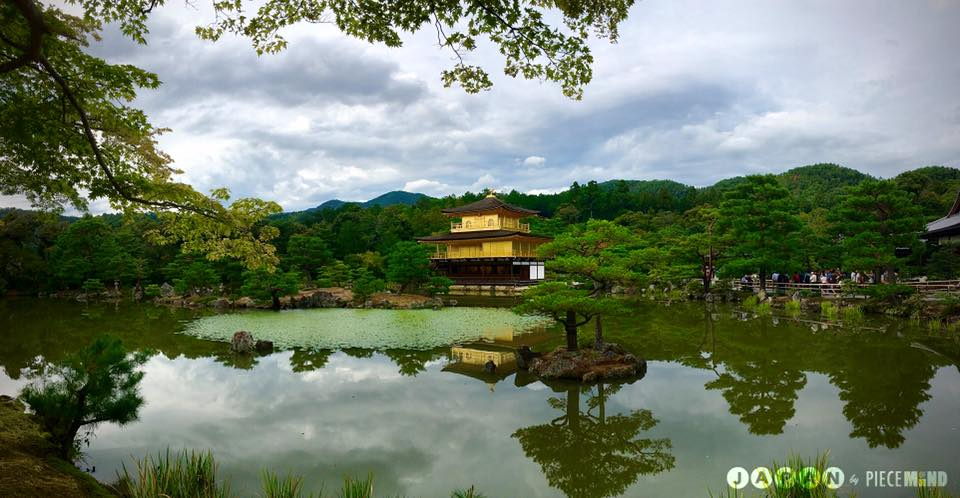

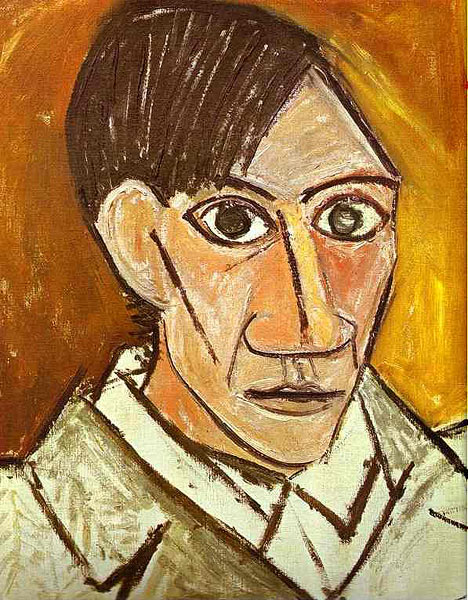

In [ ]:
from IPython.display import Image, display

display(Image(base_image_path))
display(Image(style_image_path))

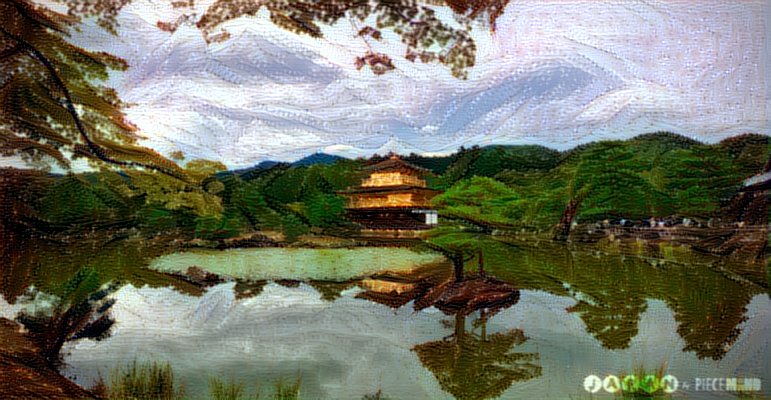

In [ ]:
display(Image(result_prefix + "_at_iteration_500.png"))
